Nuclear Magnetic Resonance Analysis 101
=====================

This notebook provides an introduction to the fundamentals of Nuclear Magnetic Resonance (NMR) data analysis. We will start with 1D NMR spectroscopy and then move on to magnetic resonance imaging (MRI). We will also look at a small selection of the many modalities available for MRI.

We will be working with some real data as collected from various instruments. This means we will have to deal with some practical issues regarding the idiosyncrasies of the various instrument vendors, but we will largely gloss over these details so as not to distract from the fundamentals.

Some basic knowledge of Python and its numerical libraries is assumed, but not required.

Getting Started
-----------------

A static version of this notebook is available [here](http://nbviewer.ipython.org/github/moloney/mr_analysis_101/blob/master/mr_analysis_101.ipynb).

The source code is available [here](https://github.com/moloney/mr_analysis_101).

With the source code and a suitable Python environment you can run a "live" version of this notebook on your own computer. This will allow you to make modifications to the notebook and see the results immediately.

### Getting Python


You will need Python along with some of its numeric/scientific packages to run this notebook. If you are on Windows I recommend [pythonxy](http://code.google.com/p/pythonxy/). [Anaconda](https://store.continuum.io/cshop/anaconda/) is a cross-platform option (Windows, OSX, Linux). On Linux you might also just use your distributions package manager (e.g. `apt-get install python-numpy` on Debian/Ubuntu).

The specific packages needed for this notebook are:
* numpy
* scipy
* matplotlib
* ipython
* nmrglue
* pydicom
* nibabel

In [1]:
# This helps us write code that is compatible with both Python 2 and 3
from __future__ import print_function, division

# Import some packages from the standard library
import os
from glob import glob
from copy import deepcopy

# Import some packages that are external dependencies
import numpy as np # Provides nD arrays and related functionality
from numpy.fft import fft, fftshift
import nmrglue as ng # Used to read Bruker example data
import dicom # Used to read DICOM files
import nibabel as nb # Used to read Nifti and other files types
from scipy.optimize import leastsq # Optimization routine

# Setup plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
# Uncomment this line for displays with poor contrast (i.e. projectors)
#plt.cm.gray.set_gamma(0.5)
# This is appropriate for low resolution displays, you can increase the
# default size if desired.
plt.rcParams['figure.figsize'] = (8, 6)

NMR Spectroscopy
------------------
When a group of paramagnetic molecules in a magnetic field is excited by the appropriate radio frequency (RF) pulse, they will produce an RF signal in response called a free induction decay (FID). Different molecules or different environments will produce different FID signals. We will start by simulating some FID signals.

A key parameter for any spectroscopy experiment is the sweep width, which tells us the range of frequencies that can be detected to either side of the carrier frequency.

In [2]:
sweep_width = 500.0

As an instrument receives the NMR response it digitizes it in the time domain.

In [3]:
fid_res = 2048
time = np.linspace(0, (fid_res - 1) / sweep_width, fid_res)

Now lets define a function that will simulate an FID at a single resonance frequency, given some basic parameters.

In [4]:
def simulate_fid(time, amplitude, t2, freq_offset, phase0=0.0, t0=0.0):
    fid = np.zeros(time.shape, dtype=np.complex64)
    offterm = np.zeros_like(fid)
    offterm.imag = -2.0 * np.pi * freq_offset * (time + t0)
    fid = (amplitude * 
           np.exp(-offterm) * 
           np.exp(-(time + t0) / t2) * 
           np.exp(np.complex(0, phase0)))

    return fid

The first three parameters are the key components of the signal: the amplitude, T<sub>2</sub> decay time, and the frequency (relative to the carrier frequency). 

Lets simulate and plot an FID.

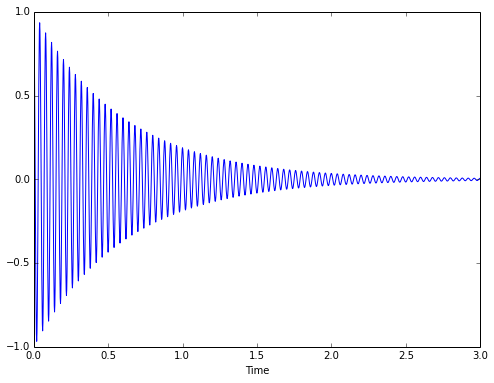

In [5]:
fid = simulate_fid(time, 1.0, 0.6, 25.0)
plt.plot(time, np.real(fid))
plt.xlim(0.0, 3.0)
plt.xlabel('Time')

If a molecule is on resonance with the carrier frequency we just see a T<sub>2</sub> decay curve. Typically water molecules are on resonance with the carrier frequency.

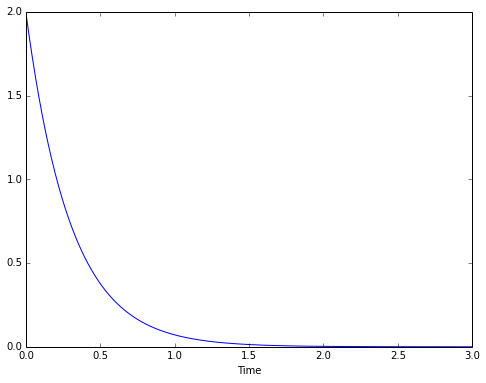

In [6]:
h2o_fid = simulate_fid(time, 2.0, 0.3, 0.0)
plt.plot(time, np.real(h2o_fid))
plt.xlim(0.0, 3.0)
plt.xlabel('Time')

In either case, with a single FID it is usually possible to estimate the amplitude, frequency, and T<sub>2</sub> by just looking at the curve. In real spectroscopy data we are going to have a mix of signals, with different amplitudes, T<sub>2</sub> values, and frequencies. Lets try mixing together a couple of simulated FID signals.

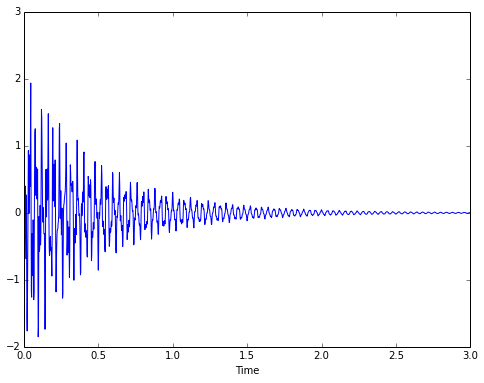

In [7]:
mixed_fid = (fid + 
             simulate_fid(time, 0.75, 0.4, 67.0) + 
             simulate_fid(time, 0.5, 0.45, 109.0) +
             simulate_fid(time, 0.5, 0.2, 129.0)
            )
plt.plot(time, np.real(mixed_fid))
plt.xlim(0.0, 3.0)
plt.xlabel('Time')

The FID shape is still recognizable but we are starting to see interference patterns. It is no longer possible to tell how many signals are mixed together, let alone their parameters, just by looking at the curve.

Therefore, one of the first steps when analyzing spectroscopy data is to apply a Fourier transform (FT) to get the data in the frequency domain (the spectrum).

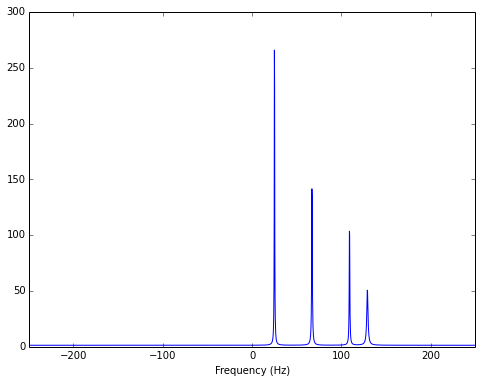

In [8]:
spec = fftshift(fft(mixed_fid))
half_sw = sweep_width / 2
freq = np.linspace(-half_sw, half_sw, fid_res)
plt.plot(freq, np.real(spec))
plt.xlim(freq[0], freq[-1])
plt.xlabel('Frequency (Hz)')

In the frequency domain we can clearly see there are four different signals, with their location on the x-axis giving us their frequencies. The height of the spikes depends on both the amplitude and T<sub>2</sub>.

Next we will be looking at some real spectroscopy data collected on a Bruker 8.5T instrument. We use the package `nmrglue` to read a directory corresponding to a single experiment. It produces a dictionary of meta data and a numpy array of the readout data. 

In [9]:
spect_path = os.path.join('example_data', 'bruker_spect')
spect_meta, spect_td_data = ng.bruker.read(spect_path)
print("data type = %s" % spect_td_data.dtype)
print("data shape = %s" % spect_td_data.shape)

data type = complex128
data shape = 8192


As we can see, our data is complex (two double precision floats) and we have 8,192 samples in a single vector. Lets go ahead and take a look at the real component of our data.

Sweep width = 4310.344828 Hz
Dwell time = 116.000000 us


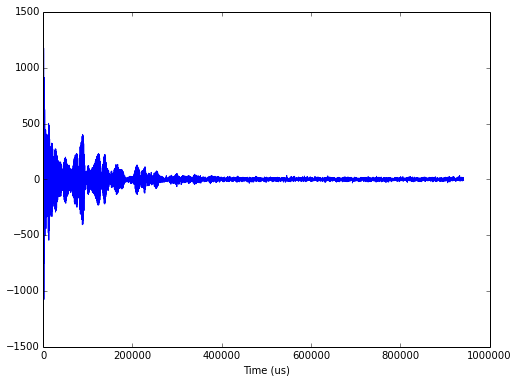

In [10]:
# Bruker idiosyncrasy
spect_td_data = ng.bruker.remove_digital_filter(spect_meta, spect_td_data)
sweep_width = spect_meta['acqus']['SW_h'] # Bruker specific location
dwell_time = 1e6 / (sweep_width * 2) # We need two readout samples per Hz
print("Sweep width = %f Hz" % sweep_width)
print("Dwell time = %f us" % dwell_time)
x_time = np.linspace(0, 
                     (spect_td_data.shape[0] - 1) * dwell_time, 
                     spect_td_data.shape[0])
plt.plot(x_time, np.real(spect_td_data))
plt.xlabel('Time (us)')

Despite the interference patterns from mixing frequencies, the data has the easily recognizable shape of a free induction decay (FID).

Again we need to transform the data into the frequency domain.

(-1100, -500)

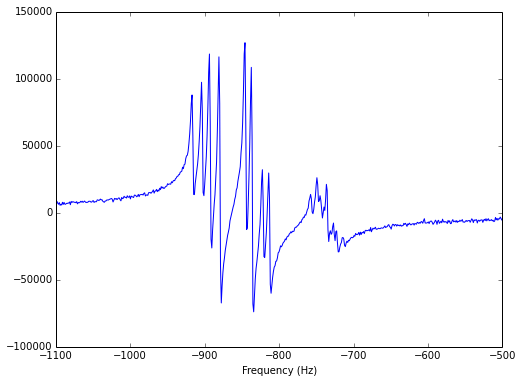

In [11]:
# The fftshift centers the data around zero
spect_fd_data = np.fft.fftshift(np.fft.fft(spect_td_data)) 
x_freq = np.linspace(-sweep_width, sweep_width, spect_fd_data.shape[0])
plt.plot(x_freq, np.real(spect_fd_data))
plt.xlabel("Frequency (Hz)")
plt.xlim(-1100, -500) # Zoom in on the action

In an ideal world, the real component in the frequency domain would give us the absorption spectrum (what we want) from the sample and the imaginary component would give us the dispersion spectrum. As you can see in the plot above, this does not hold true in the real world and the components end up mixing. 

To address this we need to perform a phase correction. Lets look at the results from doing phase corrections with a range of angles.

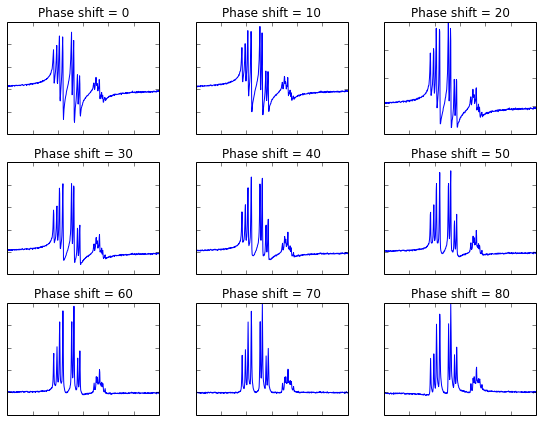

In [12]:
fig, ax_array = plt.subplots(3, 3)
fig.tight_layout()
for p_idx, phase_shift in enumerate(range(0, 90, 10)):
    ax = ax_array.flat[p_idx]
    ax.plot(x_freq, np.real(ng.proc_base.ps(spect_fd_data, phase_shift)))
    ax.set_xlim(-1100, -500)
    ax.set_title("Phase shift = %d" % phase_shift)
    ax.tick_params(axis='both', 
                   which='both', 
                   labelleft='off', 
                   labelbottom='off')

The 70 degree phase shift gives the best result here. We could do more fine tuning but this is good enough for now.

In [13]:
final_spect_data = ng.proc_base.ps(spect_fd_data, 70)

A common approach to automatically identifying peaks in an NMR spectrum is to fit a linear combination of basis sets to the data, where each basis set corresponds to a different paramagnetic compound.

We will load two basis sets and a spectrum that contains those two. The spectrum has already been phase corrected

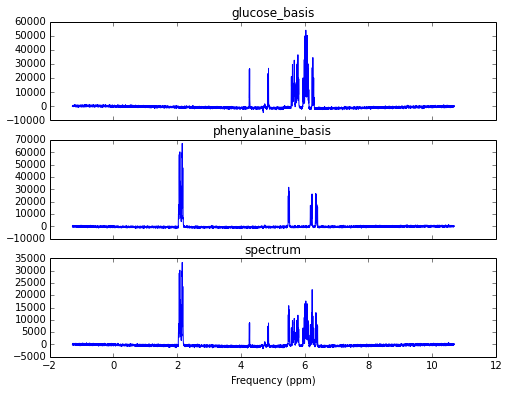

In [14]:
basis_data = np.load(os.path.join('example_data', 
                                  'basis_fit.npz'))
fig, ax_array = plt.subplots(3, 1, sharex=True)
#fig.tight_layout()
for idx, name in enumerate(('glucose_basis', 
                            'phenyalanine_basis', 
                            'spectrum')):
    ax = ax_array[idx]
    ax.plot(basis_data['freq'], np.real(basis_data[name]))
    ax.set_title(name)
ax_array[-1].set_xlabel('Frequency (ppm)')

Since we are looking for a linear combination of the two basis signals we could solve a matrix formulation of the problem. In fact that is the most common approach for this type of analysis. However, as a prelude to some processing we will be doing later we will solve this as a minimization problem.

First we must define a model function. The model function has two parameters we wish to optimize, the linear weight for each basis function.

In [15]:
def spect_model(model_params, basis_spects):
    fit_data = np.zeros_like(basis_spects[0])
    for idx, weight in enumerate(model_params):
        fit_data += weight * basis_spects[idx]
    return fit_data

In order to pose this as a minimization function we must create a function the returns the residuals.

In [16]:
def error_func(model_params, model_func, model_args, observed):
    return np.abs(observed - model_func(model_params, *model_args))

Now we can use `scipy.optimize.leastsq` to solve the minimization problem.

In [17]:
basis_sets = [basis_data['glucose_basis'], 
              basis_data['phenyalanine_basis']
             ]
basis_weights, cov = leastsq(error_func,
                             [1.0, 1.0],
                             args=(spect_model, 
                                   (basis_sets,), 
                                   basis_data['spectrum'])
                            )
print("Glucose weight = %f" % basis_weights[0])
print("Phenyalanine weight = %f" % basis_weights[0])

Glucose weight = 0.333333
Phenyalanine weight = 0.333333


It looks like we have equal parts glucose and phenyalanine in this spectrum. Finally we can plot the modeled and actual spectrum together to make sure the results look correct.

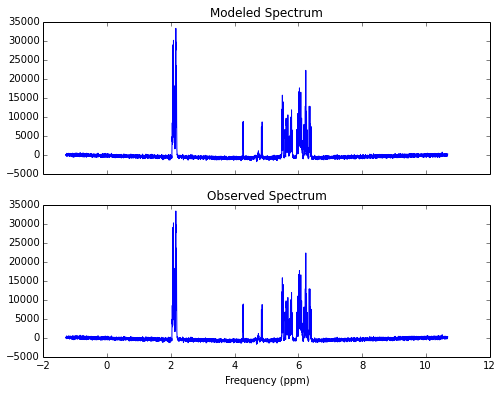

In [18]:
fig, ax_array = plt.subplots(2, sharex=True)
ax_array[0].plot(basis_data['freq'], np.real(spect_model(basis_weights, basis_sets)), 'b-')
ax_array[0].set_title('Modeled Spectrum')
ax_array[1].plot(basis_data['freq'], np.real(basis_data['spectrum']), 'b-')
ax_array[1].set_title('Observed Spectrum')
ax_array[1].set_xlabel('Frequency (ppm)')

Magnetic Resonance Imaging
-----------------------------

The principles behind NMR spectroscopy also lie behind magnetic resonance imaging (MRI). Instead of trying to excite a range of molecules we focus on exciting the most abundant one, water. Using smaller "gradient" magnets with orthogonal orientations, we force variations in the frequency and phase of the water signal over the spatial extent we are imaging. This encodes the spatial location of each signal we receive from the resonating water molecules. 

Or to think about it the other way around, each pixel in the image has its water signal "packaged" into a small range of frequencies/phases so we can tell it apart from the signal coming from other pixels. The precise method of achieving this packaging is determined by what is called a pulse sequence. The pulse sequence describes a time line of radio frequency (RF) pulses and gradient magnet activations. There are many different types of pulse sequences, each with different strengths and often different applications.

The concept of k-space brings some common ground to this wide variety of pulse sequences. Each pulse sequence may fill in parts of k-space in a different manner, but the end result should produce an image through a Fourier transform.
The number of dimensions in our k-space data typically matches the number of dimensions in our desired image, though it isn't uncommon to over sample in the frequency encoding direction. A basic two dimensional gradient recalled echo (GRE) image will use frequency encoding for each row of pixels and phase encoding for each column (or vice versa).

Lets load such a data set and take a look at it.

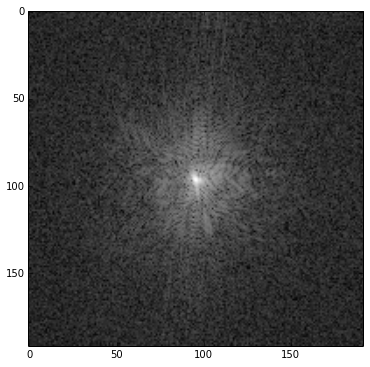

In [19]:
kspace_path = os.path.join('example_data', '2d_gre.img')
# We know the image dimensions/dtype
kspace_data = np.fromfile(kspace_path, 
                          dtype=np.complex64).reshape(192, 192)
# Log transform to compress dynamic range
plt.imshow(np.log(1 + np.abs(kspace_data)), cmap='gray')

Again we need to use the FFT to transform the data, but this time we are going from the frequency domain to the spatial domain.

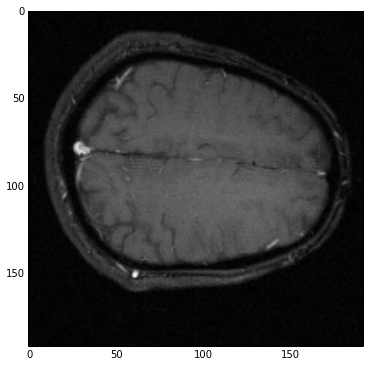

In [20]:
mag_img = np.abs(np.fft.fftshift(np.fft.fft2(kspace_data)))
plt.imshow(mag_img, cmap='gray')

As you can see, image reconstruction from k-space can be very simple. This pulse sequence is also quite simple and inefficient in terms of scan time. Looking at the original k-space data we can see that the overwhelming majority of the signal is in the center. Intuitively this makes sense as the center of k-space corresponds to low spatial frequencies in the image, and this image is almost entirely composed of low spatial frequencies.

This is one of the easiest ways of reducing scan time; just don't acquire all of k-space. Let see what happens if we zero out some parts of k-space before image reconstruction. First lets create a function that will help us compare two k-space images.

In [21]:
def cmp_kspace(full, partial):
    full_img = np.abs(np.fft.fftshift(np.fft.fft2(full)))
    partial_img = np.abs(np.fft.fftshift(np.fft.fft2(partial)))
    gs = gridspec.GridSpec(2, 3)
    gs.update(wspace=0.025, hspace=0.05)
    ax_list = [plt.subplot(gs[i]) for i in range(6)]
    ax_list[0].imshow(np.log(1 + np.abs(full)), cmap='gray')
    ax_list[0].set_title("Original Acquisition")
    ax_list[1].imshow(np.log(1 + np.abs(partial)), cmap='gray')
    ax_list[1].set_title("Modified Acquisition")
    ax_list[2].imshow(np.abs(full - partial), cmap='gray')
    ax_list[2].set_title("Difference")
    ax_list[3].imshow(full_img, cmap='gray')
    ax_list[4].imshow(partial_img, cmap='gray')
    ax_list[5].imshow(np.abs(full_img - partial_img), cmap='gray')
    for ax in ax_list:
        ax.tick_params(axis='both', 
                       which='both', 
                       labelleft='off', 
                       labelbottom='off')

We can simulate a pulse sequence that does not acquire the outer portions of k-space by applying a box filter to the k-space data. You can try increasing `trim_ratio` below and seeing how high you can go before the image looks blurry.

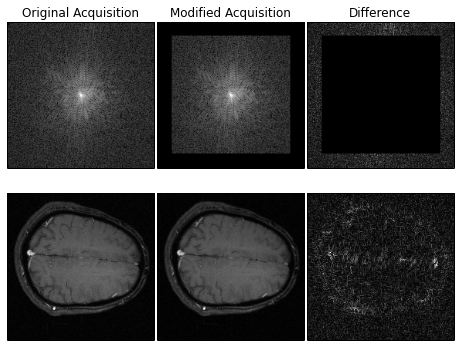

In [22]:
mod_kspace = kspace_data.copy()
trim_ratio = .10
n_trim = int(mod_kspace.shape[0] * trim_ratio)
mod_kspace[:n_trim, :] = 0
mod_kspace[-n_trim:, :] = 0
mod_kspace[:, :n_trim] = 0
mod_kspace[:, -n_trim:] = 0
cmp_kspace(kspace_data, mod_kspace)

In terms of scan time, frequency encoding is much cheaper than phase encoding. The k-space data is also mostly symmetric. Lets see what happens if we zero a little less than half the data along one axis (the phase encoding axis).

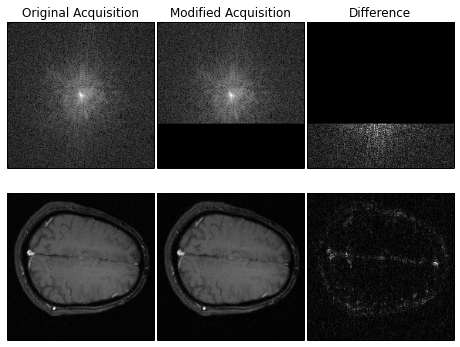

In [23]:
mod_kspace = kspace_data.copy()
cutoff = int(192 * 0.7)
mod_kspace[cutoff:, :] = 0
cmp_kspace(kspace_data, mod_kspace)

As you can see, making dramatic changes in the k-space can have relatively minor effects on the resulting image. However, in other situations relatively small changes in the k-space data can have a dramatic effect on the image.

Lets take a look at the effect of some relatively small defects in the k-space data. First we will try adding a small spike to the k-space data, simulating a voltage spike.

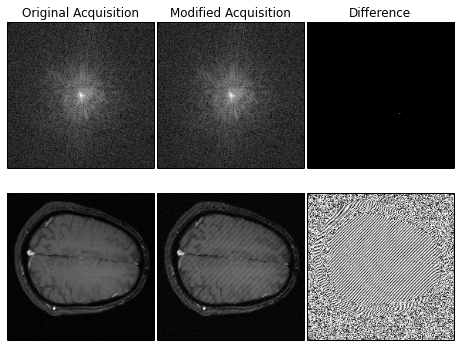

In [24]:
mod_kspace = kspace_data.copy()
mod_kspace[120, 120] = np.max(kspace_data)
cmp_kspace(kspace_data, mod_kspace)

You can try moving the spike around in the k-space image and see what effect that has on the reconstructed image. You can also try reducing the amplitude of the spike.

Sometimes we may have an entire readout line corrupted by a voltage spike. Lets take a look at what happens to the image in this case.

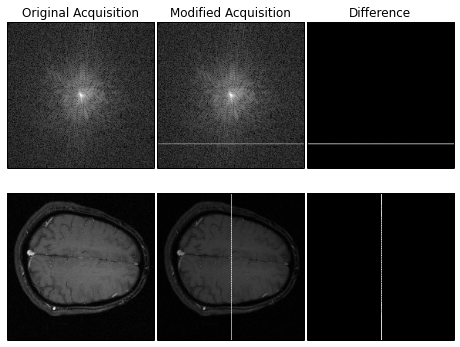

In [25]:
mod_kspace = kspace_data.copy()
mod_kspace[160, :] = np.max(kspace_data)/4
cmp_kspace(kspace_data, mod_kspace)

Again you can play around with the location and amplitude of the defect.

DICOM Files
------------

Almost any instrument that is capable of imaging can produce reconstructed images in DICOM format, and for the majority of systems this is the only way data is made available. Typically only magnitude images are produced, but phase images are sometimes an option. The data is also typically reduced to 12-bits of dynamic range.

The DICOM format does provide a wealth of meta data, describing aspects of the acquisition and subject. In many ways the format is impractical to work with for quantitative analysis: typically a single 2D image per file, complex format, difficult to write, proprietary extensions, etc. Often the first step in analysis is to convert away from DICOM images into another format, with Nifti being the most common. Nevertheless, it is important to have some familiarity with the format, especially some of the meta data it can provide.

To start we will load a set of DICOM images from a multi-echo experiment. We have a single slice with 16 time points, each corresponding to a different echo time (TE).

In [26]:
dicom_paths = glob(os.path.join('example_data', 'dicom', '*.dcm'))
dicom_files = [dicom.read_file(p) for p in dicom_paths]
print(len(dicom_files))

16


There is a huge amount of meta data available in DICOM files. Each element of meta data has a numeric "tag" (two four digit hex numbers) and any standard element also has a name. We can dump the meta data elements from the first file line-by-line by just printing it. On each line we get (left to right): numeric tag, tag name, value representation, and value.

In [28]:
print(dicom_files[0])

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008, 0012) Instance Creation Date              DA: '19000101'
(0008, 0013) Instance Creation Time              TM: '080807.421000'
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 2.25.22365617508827899449092257361
(0008, 0020) Study Date                          DA: '19000101'
(0008, 0021) Series Date                         DA: '19000101'
(0008, 0022) Acquisition Date                    DA: '19000101'
(0008, 0023) Content Date                        DA: '19000101'
(0008, 0030) Study Time                          TM: '075653.171000'
(0008, 0031) Series Time                         TM: '080807.359000'
(0008, 0032) Acquisition Time                    TM: '080319.325000'
(0008, 0033) Content Time                        TM: '080807.421000'
(0008, 0050) Accession 

You may have noticed many values are "anon" or have a date of January 1st 1901.  This is due to the data being passed through an anonymizer. Researchers have to be careful when sharing data in DICOM format as the files may contain private health information (PHI).

The `pydicom` package allows access to individual elements through dictionary lookups using a numeric tag, or access to the element values through attributes named by the element keyword (the element name with spaces and apostrophes removed). 

In [29]:
print(dicom_files[0][(0x28, 0x30)])
print(dicom_files[0][(0x28, 0x30)].value)
print(dicom_files[0].PixelSpacing)

(0028, 0030) Pixel Spacing                       DS: ['0.75', '0.75']
['0.75', '0.75']
['0.75', '0.75']


We can also iterate through the elements in the DICOM file.

In [30]:
for elem in dicom_files[0]:
    if 'coil' in elem.name.lower():
        print(elem)

(0018, 1251) Transmit Coil Name                  SH: 'CP_Extremity'


The "value representation" is a two letter code that tells us how a value is stored.

In [31]:
print(dicom_files[0][(0x8, 0x32)])
print(dicom_files[0][(0x8, 0x32)].VR)
print(type(dicom_files[0][(0x8, 0x32)].value))

(0008, 0032) Acquisition Time                    TM: '080319.325000'
TM
<type 'str'>


The 'TM' value representation uses a string to store a time of day in the format 'HHMMSS.frac', meaning this particular image was acquired about a third of a second after 8:03:19AM.

Lets go ahead and sort the files by echo time and extract the echo time values.

In [32]:
dicom_files.sort(key=lambda x: x.EchoTime)
echo_times = [dcm.EchoTime for dcm in dicom_files]
print(echo_times)

['20', '40', '60', '80', '100', '120', '140', '160', '180', '200', '220', '240', '260', '280', '300', '320']


Now lets take a look at the image series. The `pixel_array` attribute provides the image as a `numpy` array.

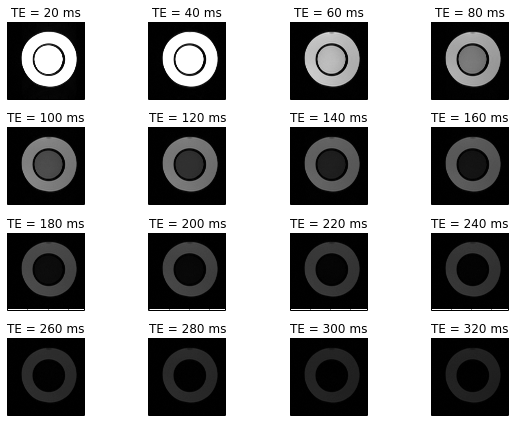

In [33]:
fig, ax_array = plt.subplots(4, 4)
fig.tight_layout()
max_val = np.max(dicom_files[0].pixel_array)
for dcm_idx, dcm in enumerate(dicom_files):
    ax = ax_array.flat[dcm_idx]
    ax.imshow(dcm.pixel_array, cmap='gray', vmax=max_val)
    ax.set_title("TE = %d ms" % dcm.EchoTime)
    ax.tick_params(axis='both', 
                   which='both', 
                   labelleft='off', 
                   labelbottom='off')

The object being scanned clearly has two sections, each with a different T<sub>2</sub> value.  Each pixel in the image has a vector of intensities corresponding to the increasing echo times.

We can select a pixel from each section and plot their decay curves.

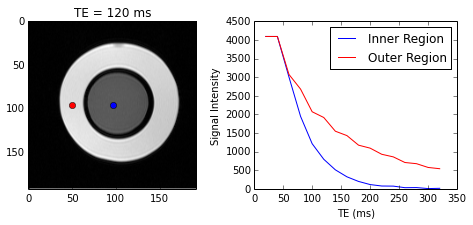

In [34]:
inner_idx = (96, 96)
outer_idx = (96, 50)
gs = gridspec.GridSpec(1, 2, height_ratios=[1,1])
ax_array = [plt.subplot(gs[i]) for i in range(2)]
ax_array[0].set_title('TE = %d ms' % echo_times[5])
ax_array[0].imshow(dicom_files[5].pixel_array, cmap='gray')
ax_array[0].autoscale(False)
ax_array[0].set_ylim(192, 0)
ax_array[0].plot(inner_idx[1], inner_idx[0], 'bo')
ax_array[0].plot(outer_idx[1], outer_idx[0], 'ro')
ax_array[1].plot(echo_times, 
                 [dcm.pixel_array[inner_idx] for dcm in dicom_files], 
                 'b-',
                 label='Inner Region')
ax_array[1].plot(echo_times, 
                 [dcm.pixel_array[outer_idx] for dcm in dicom_files], 
                 'r-',
                 label='Outer Region')
ax_array[1].set_xlabel('TE (ms)')
ax_array[1].set_ylabel('Signal Intensity')
ax_array[1].legend()

The discontinuity at the second time point is a clear indicator that something is not quite right with these decay curves. Can you figure out what the issue is?

MRI Relaxometry
-----------------

If we wanted to quantify the T<sub>2</sub> values for the two regions in the previous set of images, we would create a model for the decay curves where T<sub>2</sub> is a parameter. An optimizer can then find the T<sub>2</sub> value (and other parameter values) that minimizes the difference between the model and the observed data. If we did this for every pixel (or voxel) we would end up with a quantitative T<sub>2</sub> map. Provided our model is sufficiently accurate, we would have the intrinsic T<sub>2</sub> value of the material being imaged in each voxel. This is in contrast to a qualitative T<sub>2</sub>-weighted image which merely tries to provide contrast between materials with different T<sub>2</sub> values (the image with an echo time of 120 ms would be considered T<sub>2</sub>-weighted).

Using a different acquisition sequence and a different model, we can quantify other parameters that are also intrinsic to the material being imaged. Lets work through an example where we use an inversion recovery (IR) sequence to quantify the T<sub>1</sub> value for various types of brain tissue. An inversion recovery sequence inverts the magnetic moment of the water molecules from the low energy state (aligned with the B<sub>0</sub> magnetic field) to a high energy state (aligned opposite to the B<sub>0</sub> magnetic field). Over time the water molecules recover back to the low energy state. The amount of time it takes for this recovery is proportional to the T<sub>1</sub> value of the material. The time since the inversion is called the inversion time (TI).

We'll start by loading the data from a Nifti file.

In [35]:
ir_nii = nb.load(os.path.join('example_data', 'ir.nii.gz'))
ir_data = ir_nii.get_data()
print(ir_data.shape)

(96, 128, 1, 8)


We have 96 by 128 in-plane resolution, one slice, and eight time points. In this case each time point corresponds to a different inversion time. Lets take a look at the images across inversion times.

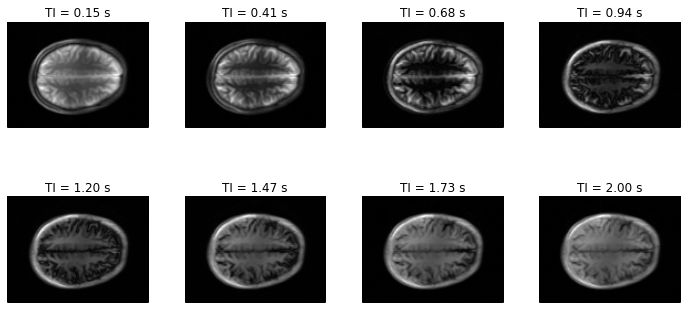

In [36]:
inv_times = np.array([147.38, 
                      411.74, 
                      676.1, 
                      940.46, 
                      1204.82, 
                      1469.18, 
                      1733.54, 
                      1997.9])
inv_times /= 1000.0 # Convert from milliseconds to seconds
fig, ax_array = plt.subplots(2, 4, figsize=(10, 5))
fig.tight_layout()
for ax_idx in range(8):
    ax = ax_array.flat[ax_idx]
    ax.imshow(ir_data[:,:,0,ax_idx], cmap='gray')
    ax.set_title("TI = %.2f s" % inv_times[ax_idx])
    ax.tick_params(axis='both', 
                   which='both', 
                   labelleft='off', 
                   labelbottom='off')

Now lets select two voxels and look at their curves. We select one white matter and one gray matter pixel.

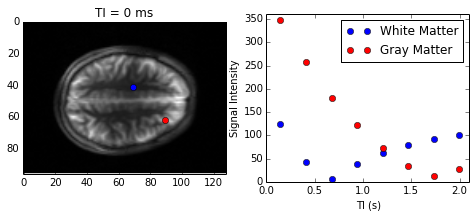

In [37]:
wm_idx = (41, 69)
gm_idx = (62, 89)
wm_curve = ir_data[wm_idx[0], wm_idx[1], 0, :]
gm_curve = ir_data[gm_idx[0], gm_idx[1], 0, :]
gs = gridspec.GridSpec(1, 2, height_ratios=[1,1])
ax_array = [plt.subplot(gs[i]) for i in range(2)]
ax_array[0].set_title('TI = %d ms' % inv_times[1])
ax_array[0].imshow(ir_data[:, :, 0, 1], cmap='gray')
ax_array[0].autoscale(False)
ax_array[0].set_ylim(96, 0)
ax_array[0].plot(wm_idx[1], wm_idx[0], 'bo')
ax_array[0].plot(gm_idx[1], gm_idx[0], 'ro')
ax_array[1].plot(inv_times, wm_curve, 'bo', label='White Matter')
ax_array[1].plot(inv_times, gm_curve, 'ro', label='Gray Matter')
ax_array[1].set_xlabel('TI (s)')
ax_array[1].set_xlim(0, 2.1)
ax_array[1].set_ylabel('Signal Intensity')
ax_array[1].set_ylim(0, 360)
ax_array[1].legend()

Again we have a discontinuity in the curves which is indicative of a potential issue. The cause of the discontinuity is that we are looking at magnitude images derived from the complex data produced by the scanner. We have essentially thrown away the sign of the magnetization, which tells us if the magnetization vector is in the same hemisphere as B<sub>0</sub>. If we had kept the sign, our inversion recovery data would start negative (aligned opposite to B<sub>0</sub>) and then become positive as the magnetization recovers into the same hemisphere as our B<sub>0</sub> direction.

If we had a phase image to go along with our magnitude images we could automatically correct the sign for each point on each curve.  Lets just do it manually to see what our curves would look like.

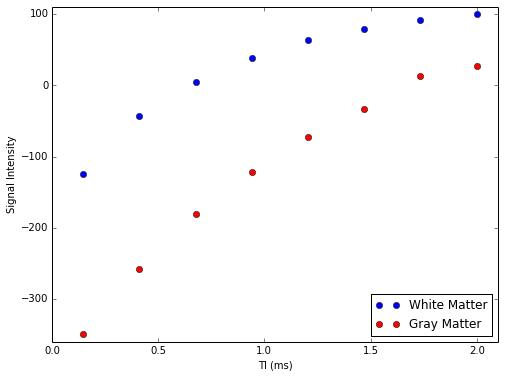

In [38]:
signed_wm_curve = wm_curve * \
    np.array([-1 for _ in range(2)] + [1 for _ in range(6)])
signed_gm_curve = gm_curve * \
    np.array([-1 for _ in range(6)] + [1 for _ in range(2)])
plt.plot(inv_times, signed_wm_curve, 'bo', label='White Matter')
plt.plot(inv_times, signed_gm_curve, 'ro', label='Gray Matter')
plt.xlabel('TI (ms)')
plt.xlim(0, 2.1)
plt.ylabel('Signal Intensity')
plt.ylim(-360, 110)
plt.legend(loc='lower right')

These curve shapes are much more in line with what we would expect to see for an exponential recovery. 

Now lets try fitting a model to our data. The fundamental equation for the amount of signal we expect at any given time after a 180 degree inversion is:

$$M_t = M_0 * (1 - 2\exp(-t/T_1))$$

Lets define a function that evaluates this equation.

In [39]:
def ir_model(model_params, inv_times):
    t1, m0 = model_params
    return m0 * (1.0 - (2.0 * np.exp(-inv_times / t1)))

We can fit this model to our recovery curves in the same manner as we fit the spectroscopy data previously.

It is often important to provide a reasonable initial guess to the optimizer if you want to get a good result. The maximum signal is a reasonable guess for M<sub>0</sub> since we have the maximum signal at full relaxation. One second is in the ballpark for T<sub>1</sub> in tissue.

In [40]:
signed_wm_params, _ = leastsq(error_func, 
                              [1.0, np.max(wm_curve)], 
                              args=(ir_model, 
                                    [inv_times], 
                                    signed_wm_curve)
                             )
signed_gm_params, _ = leastsq(error_func, 
                              [1.0, np.max(gm_curve)], 
                              args=(ir_model, 
                                    [inv_times], 
                                    signed_gm_curve)
                             )
print("White matter T1/M0 = %f %f" % tuple(signed_wm_params))
print("Gray matter T1/M0 = %f %f" % tuple(signed_gm_params))

White matter T1/M0 = 0.999540 150.395291
Gray matter T1/M0 = 2.405793 377.346905


We can feed the optimal parameters back into the model to see the curve shape of the result. We can even bump up the resolution on the x-axis to make it easier to see the shape we are modeling.

Lets define a function that will plot the data points along with the curve we get from the model.

In [41]:
def plot_modeled(x_vals, cinfo, model_func, legend_loc='lower right'):
    high_res_x = np.linspace(np.min(x_vals), np.max(x_vals), 100)
    c_idx = 0
    colors = 'brgk'
    for name, curve, params in cinfo:
        color = colors[c_idx]
        modeled = model_func(params, high_res_x)
        plt.plot(x_vals, 
                 curve, 
                 color + 'o', 
                 label='%s - Observed' % name)
        plt.plot(high_res_x, 
                 modeled, 
                 color + '-', 
                 label='%s - Modeled' % name)
        c_idx += 1
    plt.legend(loc=legend_loc)
    plt.xlabel('TI (ms)')
    plt.ylabel('Signal Intensity')

Now we can use this function to look at our results.

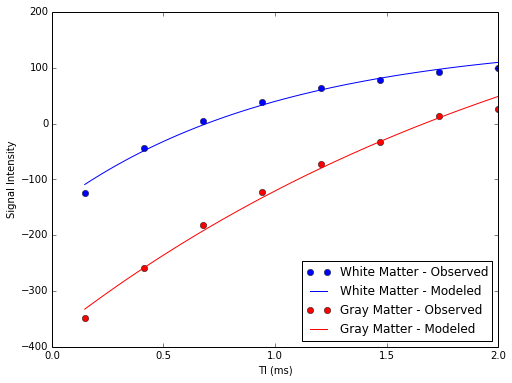

In [42]:
plot_modeled(inv_times, 
             (('White Matter', signed_wm_curve, signed_wm_params),
              ('Gray Matter', signed_gm_curve, signed_gm_params)
             ),
             ir_model)

So what if we don't want to manually correct the signs of our data points? Can we instead build this into the model directly? Modifying the model is actually as easy as taking the absolute value of our previous model.

In [43]:
def abs_ir_model(model_params, inv_times):
    return np.abs(ir_model(model_params, inv_times))

Lets try using this model to fit the original data and see if our results are comparable.

In [44]:
wm_params, _ = leastsq(error_func, 
                       [1.0, np.max(wm_curve)], 
                       args=(abs_ir_model, [inv_times], wm_curve))
gm_params, _ = leastsq(error_func, 
                       [1.0, np.max(gm_curve)], 
                       args=(abs_ir_model, [inv_times], gm_curve))
print("White matter T1/M0 = %f %f" % tuple(wm_params))
print("Gray matter T1/M0 = %f %f" % tuple(gm_params))

White matter T1/M0 = 1.020143 152.333363
Gray matter T1/M0 = 2.405793 377.346906


Our gray matter parameters are identical between the two models, but our white matter T<sub>1</sub> has increased slightly.  Our two models should be identical, so why the discrepancy? We can take a look at the plot to compare to our previous result.

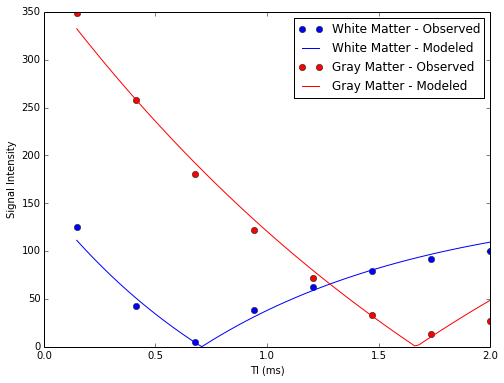

In [45]:
plot_modeled(inv_times, 
             (('White Matter', wm_curve, wm_params),
              ('Gray Matter', gm_curve, gm_params)
             ),
             abs_ir_model,
             'upper right')

The difference may not be obvious at first glance. Basically the optimizer found a better fit by putting the zero point between the third and fourth data point in the white matter curve. When we manually corrected the signs we only negated the first two points.

So the optimizer did a better job of fixing the signs than we did manually. However there is a trade off when we increase the model complexity like this, even though we are not adding any parameters to the model. To illustrate this point, lets imagine a scenario where we only collected the first four inversion times instead of eight (perhaps we want to reduce the total scan time for the experiment).

White matter T1/M0: 0.949628 168.701667 


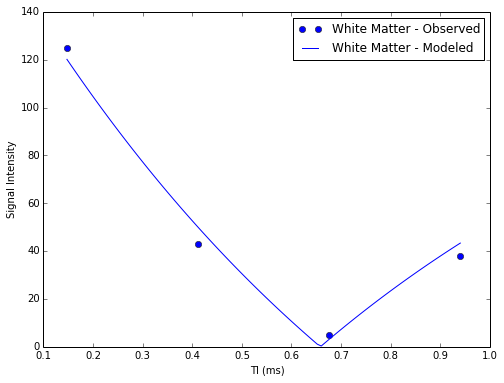

In [49]:
crop_wm_curve = wm_curve[:4]
crop_inv_times = inv_times[:4]
crop_wm_params, _ = leastsq(error_func, 
                            [1.0, np.max(crop_wm_curve)], 
                            args=(abs_ir_model, 
                                  [crop_inv_times], 
                                  crop_wm_curve)
                           )
print("White matter T1/M0: %f %f " % tuple(crop_wm_params))
plot_modeled(crop_inv_times,
             (('White Matter', crop_wm_curve, crop_wm_params),),
             abs_ir_model,
             'upper right')

The zero point has moved back to the left of the third point and our optimized values have changed significantly.  This isn't too surprising, after all we have less data to characterize the shape of our curve.

However, you might be surprised if we compare the "error surface" for our two models for this data. The error surface is what our optimizer is trying to find the minimum of (and really it is only a 2D surface in this case since we have two model parameters).

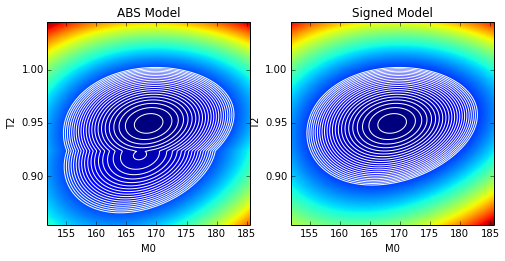

In [50]:
crop_signed_wm_curve = signed_wm_curve[:4]
err_res = (200, 200)
t2_range = np.linspace(crop_wm_params[0] * 0.9, 
                       crop_wm_params[0] * 1.1, 
                       err_res[0])
m0_range = np.linspace(crop_wm_params[1] * 0.9, 
                       crop_wm_params[1] * 1.1, 
                       err_res[1])
abs_err_surf = np.empty(err_res)
signed_err_surf = np.empty(err_res)
for t2_idx, t2_val in enumerate(t2_range):
    for m0_idx, m0_val in enumerate(m0_range):
        abs_err_surf[t2_idx, m0_idx] = \
            np.sum(error_func([t2_val, m0_val], 
                   abs_ir_model, 
                   [crop_inv_times], 
                   crop_wm_curve) ** 2
                  )
        signed_err_surf[t2_idx, m0_idx] = \
            np.sum(error_func([t2_val, m0_val], 
                              ir_model, 
                              [crop_inv_times], 
                              crop_signed_wm_curve) ** 2
                  )
contour_levels = [6 * x for x in range(40)]
fig, ax_array = plt.subplots(1, 2)
im_extent = (m0_range[0], m0_range[-1], t2_range[0], t2_range[-1])
ct_extent = (m0_range[0], m0_range[-1], t2_range[-1], t2_range[0])
aspect = float((im_extent[1] - im_extent[0]) / 
               (im_extent[3] - im_extent[2]))
ax_array[0].imshow(abs_err_surf, extent=im_extent)
ax_array[0].contour(abs_err_surf, 
                    contour_levels, 
                    colors='w', 
                    extent=ct_extent)
ax_array[0].set_aspect(aspect)
ax_array[0].set_title("ABS Model")
ax_array[0].set_xlabel('M0')
ax_array[0].set_ylabel('T2')
ax_array[1].imshow(signed_err_surf, extent=im_extent)
ax_array[1].contour(signed_err_surf, 
                    contour_levels, 
                    colors='w', 
                    extent=ct_extent)
ax_array[1].set_aspect(aspect)
ax_array[1].set_title("Signed Model")
ax_array[1].set_xlabel('M0')
ax_array[1].set_ylabel('T2')

As you can see, our model that takes the absolute value has a local minima near the global minimum. These two minimas correspond to whether zero crossing comes before or after the third data point.

Even though the global minimum is significantly smaller than the local minima, an optimizer can get stuck in the local minima and thus report non-optimal parameter values.

Functional Magnetic Resonance Imaging
------------------------------------------
One of the greatest strengths of MRI is its ability to detect a wide range of contrasts. It is even possible to detect contrasts from physiological processes. A famous example of this is the blood-oxygen level dependent (BOLD) contrast, which can be used to infer increased brain activity in different regions of the brain in response to some stimulus. The increase in blood oxygen results in an increased T<sub>2</sub><sup>*</sup>.

We are going to analyze a data set where the subject was alternatingly exposed and not exposed to some auditory stimulus. We have a subset of the full data set (three slices from the middle of the brain) already converted to Nifti format.

In [51]:
fmri_nii = nb.load(os.path.join('example_data', 'fmri.nii.gz'))
fmri_data = fmri_nii.get_data()
print(fmri_data.shape)

(160, 160, 3, 60)


We can see that our in-plane resolution is 160 by 160, we have three slices, and 60 time points. Lets generate a mean image across all time points and take a look at it.

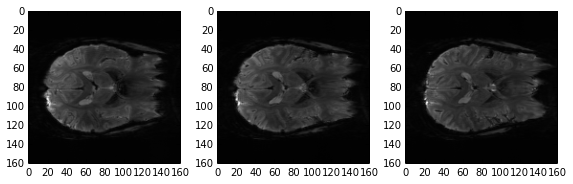

In [52]:
fmri_mean = np.mean(fmri_data, axis=3)
fig, ax_array = plt.subplots(1, 3)
fig.tight_layout()
for ax_idx in range(3):
    ax_array[ax_idx].imshow(fmri_mean[:,:,ax_idx], cmap='gray')

The distortion of the frontal lobe is a result of the type of acquisition used here, echo planar imaging (EPI). This acquisition is extremely fast but also suffers from this distortion in areas with large changes in magnetic susceptibility, in this case the frontal sinuses. The distortion here is also amplified due to the strong magnetic field (7T). There are techniques to reduce or correct for this effect, but we will not discuss them here. Luckily the auditory regions are not in the frontal lobe.

The experiment followed a block design. For the first 10 frames the stimulus was on, for the next ten it was off, then back on and so on. There are a total six blocks, three on and three off, for our 60 time points.

The simplest way to look for contrast between these blocks is to average them and subtract.

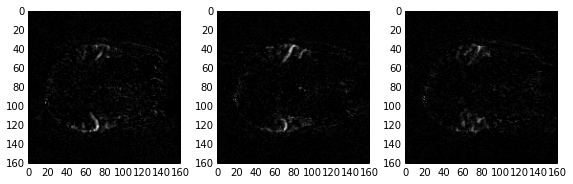

In [53]:
block_means = [np.mean(fmri_data[:,:,:,idx:idx+10], axis=3) 
               for idx in xrange(0, 60, 10)]
on_means = np.concatenate([b[..., np.newaxis] 
                           for b in block_means[::2]], axis=3)
on_mean = np.mean(on_means, axis=3)
off_means = np.concatenate([b[..., np.newaxis] 
                            for b in block_means[1::2]], axis=3)
off_mean = np.mean(off_means, axis=3)
fmri_diff = on_mean - off_mean
fmri_diff[fmri_diff < 0] = 0
fig, ax_array = plt.subplots(1, 3)
fig.tight_layout()
for ax_idx in range(3):
    ax_array[ax_idx].imshow(fmri_diff[:,:,ax_idx], cmap='gray')

We can see a clear pattern of increased T<sub>2</sub><sup>*</sup>-weighted signal in two regions. Lets overlay the the enhancement image on the mean image so we can clearly see which anatomy is showing enhancement.

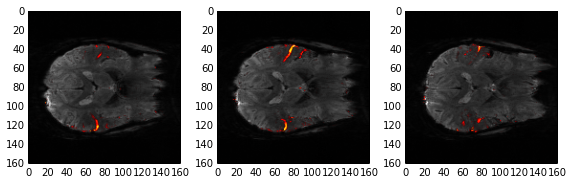

In [54]:
norm_diff = fmri_diff / np.max(fmri_diff)
fig, ax_array = plt.subplots(1, 3)
fig.tight_layout()
for ax_idx in range(3):
    ax_array[ax_idx].imshow(fmri_mean[:,:,ax_idx], cmap='gray')
    diff_rgba = plt.cm.hot(norm_diff[:,:,ax_idx])
    alpha = norm_diff[:,:,ax_idx] * 3
    alpha[alpha > 1] = 1
    diff_rgba[:,:,3] = alpha
    ax_array[ax_idx].imshow(diff_rgba)

Lets compare this to the location of the auditory cortex, shown here in the blue and green areas. ("Human temporal lobe areas" by Talbot K, Louneva N, Cohen JW, Kazi H, Blake DJ, et al. 2011)

<img src="example_data/Human_temporal_lobe_areas.png">

So it looks like we are in fact seeing increased T<sub>1</sub> in the auditory cortex while the subject is being exposed to the auditory stimulus. Lets go ahead and look at the time course in a region showing activation.

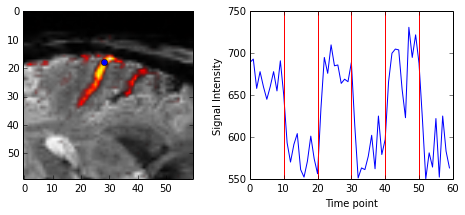

In [55]:
zoom_roi = (slice(20, 80), slice(50, 110), 1)
zoom_vox_idx = (18, 28) # Edit this to look at different voxels
zoom_mean = fmri_mean[zoom_roi]
zoom_diff = norm_diff[zoom_roi]
diff_rgba = plt.cm.hot(zoom_diff)
alpha = zoom_diff * 3
alpha[alpha > 1] = 1
diff_rgba[:, :, 3] = alpha
gs = gridspec.GridSpec(1, 2, height_ratios=[1,1])
ax_array = [plt.subplot(gs[i]) for i in range(2)]
ax_array[0].imshow(zoom_mean, cmap='gray')
ax_array[0].imshow(diff_rgba)
ax_array[0].autoscale(False)
ax_array[0].set_ylim(zoom_roi[0].stop - zoom_roi[0].start - 1, 0)
ax_array[0].plot(zoom_vox_idx[1], zoom_vox_idx[0], 'bo')
ax_array[1].plot(fmri_data[zoom_roi[0].start + zoom_vox_idx[0], 
                           zoom_roi[1].start + zoom_vox_idx[1], 
                           1, 
                           :])
ax_array[1].set_xlabel("Time point")
ax_array[1].set_ylabel("Signal Intensity")
# Place red veritcal lines at block boundaries
for b_idx in xrange(6):
    ax_array[1].axvline(b_idx * 10, color='r')
    

It easy to see the correlation between our experimental block design and the T<sub>2</sub><sup>*</sup>-weighted signal intensity in this voxel. Out ability to see this so clearly for a single voxel is due to the increased signal-to-noise ratio (SNR) afforded by the seven Tesla magnetic field strength of the instrument used in this scan.

It should be noted that any real analysis of FMRI data would not use such a simple approach. You may have noticed that the BOLD enhancement images we created show some enhancement in areas outside the auditory cortex. There are many potentially confounding factors that can cause this, but the primary candidate is subject motion. While this particular data set has been motion corrected already, there is still some residual motion. Other confounding factors include signal drift and the delay time between the activation of a region and the onset of the BOLD signal. The standard approach to separating all of these confounding factors from the contrast we are interested in is to use a general linear model (GLM). The confounding factors and the BOLD contrast are parametrized in this model which is then optimized to fit the observed data.